## _Tracking Performance_

- _Make sure the `eval_reco_trkx.py` script is run giving output as `particle.h5` with summary statistics_
- _I am using this notebook instead of `plot_trk_perf.py` script (that is left unchanged)_
- _Only using functions from the `utils_plot.py`_

Note: We can't find Tracing Purity, Clone/Duplication Rate and Fake/Ghost Rate from the _`particles.h5`_ with current variables we have.

In [1]:
import glob, os, sys, yaml

In [2]:
import math, time
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import torch
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial
from utils_plot import make_cmp_plot, pt_configs, eta_configs, get_ratio

In [4]:
import logging
from collections import namedtuple
import atlasify as atl
from atlasify import atlasify
import sklearn.metrics

In [5]:
sys.path.append("..")
device = "cuda" if torch.cuda.is_available() else "cpu"

### _Read Particles HDF5 Store_

- To consistent with resutls, we chose $MF > 50\%$, Minimum True Hits $\ge 7$ STT hits for reconstructable particles, and Minimum Reco Hits $\ge 5, 6$ for reconstucted tracks.

In [19]:
# MF > 50%, N_t >= 7 STT hits (Particles), and N_r >= 5 STT hits (Tracks)
outdir = ""
# path = "../run_all/dnn_segmenting_ln/eval/0.5_7_5_particles.h5"; out_prefix = "dnn_all"
path = "../run_all/gnn_segmenting/eval/0.5_7_5_particles.h5"
out_prefix = "gnn_all"
# path = "../run_all/fwp_gnn_segmenting/eval/0.5_7_5_particles.h5"; out_prefix = "fwp_all"

In [20]:
out_prefix

'gnn_all'

In [21]:
# load HDFStore
store = pd.HDFStore(path)

In [22]:
# store.get('data').head()
df = store["data"]

In [23]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,8,0.297051,0.0,0.0,0.0,-1,-13,0.842850,0.802331,-0.154041,17,True,True,100000
1,7,0.300384,0.0,0.0,0.0,-1,-13,0.348379,1.737425,0.987810,17,True,True,100000
2,4,0.317588,0.0,0.0,0.0,1,13,2.187110,-0.659501,-1.931183,18,True,True,100000
3,3,0.130012,0.0,0.0,0.0,1,13,0.526521,1.311128,1.288591,16,True,True,100000
4,9,1.205626,0.0,0.0,0.0,-1,-13,2.134601,-0.596292,-0.181555,17,True,True,100000


In [24]:
# Filtering: We can filter charge, pdgcode vs Tracking efficiency, OR see fiducial cuts
# df = df[df['pdgcode'].isin([-211, 211])].reset_index(drop=True)
# df = df[df['pdgcode'].isin([-2212, 2212])].reset_index(drop=True)
# df = df[df['pdgcode'].isin([-211])].reset_index(drop=True)  # pdgcodes: pbar=-2212, p=2212, piplus=211, piminus=-211
# df = df[df['q'] == 1].reset_index(drop=True)

In [25]:
# extract variables from df
pt = df.pt.values

vx = df.vx.values
vy = df.vy.values
d0 = np.sqrt(vx**2 + vy**2)
z0 = df.vz.values

charge = df.q
pdgcode = df.pdgcode

peta = df.peta.values
ptheta = (df.ptheta.values * 180) / np.pi  # radians to degrees
pphi = (df.pphi.values * 180) / np.pi  # radians to degrees

matched_idx = df.is_matched  # matched
rectable_idx = df.is_trackable  # reconstructable

In [26]:
# fiducial cuts: q, pt, eta, phi, particle type, etc.
fiducial = (charge > 0) & (pt > 0.5)

In [27]:
# add common args (pt, theta, phi and d0 have some difference)
make_cmp_plot_fn = partial(
    make_cmp_plot,
    ylabel="Particles",
    legends=[
        "Selected",
        "Selected Matched",
        "Reconstructable",
        "Reconstructable Matched",
    ],
    loc="upper right",
    ratio_ylabel="Track Finding Efficiency",
    ratio_legends=["Physics Efficiency", "Technical Efficiency"],
    ratio_loc="lower right",
    figsize=(8, 6),
    badgetext=r"Simulated: $\mu^\pm$ Pairs"
    + "\nMomentum: 100 MeV/c - 1.5 GeV/c",  # Muons, Badge Subtext
    # badgetext=r"Simulated: $\bar{p}p \rightarrow \bar{\Lambda} \:  (\bar{p}\pi^{+}) \: \Lambda \:  (p\pi^{-})$"+"\nBeam Momentum = 1.642 GeV/c", # FWP, Badge Subtext
    ref_lines=False,
)

### _1. Tranverse Momentum_

In [28]:
min(pt), max(pt)

(0.0055759577, 1.4952323)

In [29]:
# get min and max
pt_min, pt_max = min(pt), max(pt)

# linear scale on x-axis
pt_bins = np.linspace(pt_min, pt_max, num=20)

# log scale on x-axis
# pt_bins = np.logspace(np.log10(pt_min), np.log10(pt_max), 20)

# custom scale on x-axis (fwp)
# pt_bins = [0, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.35, 0.6]

In [30]:
# pt confis
pt_configs = {
    "bins": pt_bins,
    "histtype": "step",
    "lw": 1.0,
    "log": False,
}

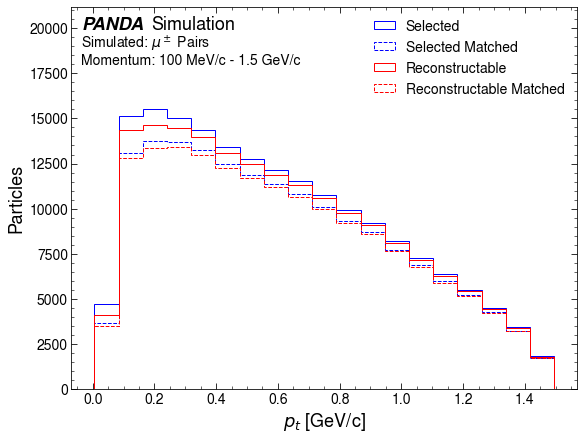

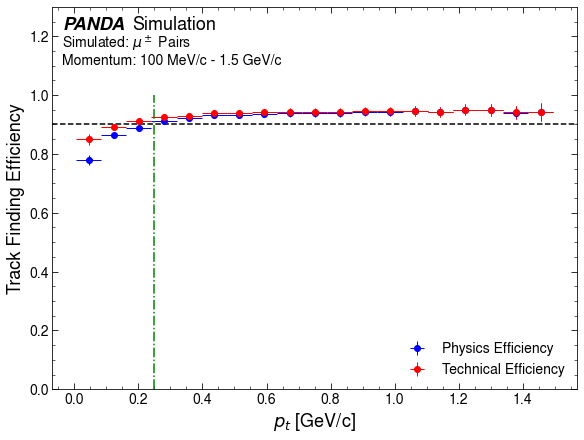

In [31]:
# vertex cuts
all_cuts = [0.0]

for cut_pt in all_cuts:

    # select cuts
    cuts = pt > cut_pt

    # get particles
    sel_particles = pt[cuts]  # selected (or generated)
    sel_matched_particles = pt[cuts & matched_idx]  # selected and matched
    reco_particles = pt[cuts & rectable_idx]  # selected reconstructable
    reco_matched_particles = pt[
        cuts & rectable_idx & matched_idx
    ]  # selected reconstructable and matched

    # make list of particles
    particles = [
        sel_particles,
        sel_matched_particles,
        reco_particles,
        reco_matched_particles,
    ]

    # make pt plots
    make_cmp_plot_fn(
        arrays=particles,
        configs=pt_configs,
        xlabel=r"$p_t$ [GeV/c]",
        ymin=0.0,
        ymax=1.0,
        ref_lines=True,
        outname=os.path.join(outdir, f"{out_prefix}_pt_cut{cut_pt}"),
    )

    # print stats
    # print("cut_pt: {}".format(cut_pt))
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))

### _2. Theta Angle_

In [32]:
min(ptheta), max(ptheta)

(7.4538045, 161.08627)

In [22]:
# get min and max
ptheta_min, ptheta_max = min(ptheta), max(ptheta)

# linear scale on x-axis
ptheta_bins = np.linspace(22, 140, num=15)

# log scale on x-axis
# ptheta_bins = np.logspace(np.log10(ptheta_min), np.log10(ptheta_max), 20)

# custom scale on x-axis
# ptheta_bins = [22, 28, 34, 40, 46, 52, 58, 64, 74, 84, 92, 105, 120, 142]

In [23]:
# theta configs
ptheta_configs = {"bins": ptheta_bins, "histtype": "step", "lw": 1, "log": False}

### _3. Phi Angle_

In [24]:
min(pphi), max(pphi)

(-179.99686, 179.99643)

In [25]:
# get min and max
pphi_min, pphi_max = min(pphi), max(pphi)

# linear scale on x-axis
pphi_bins = np.linspace(-180, 180, num=15)

In [26]:
# phi configs
pphi_configs = {"bins": pphi_bins, "histtype": "step", "lw": 1, "log": False}

### _4. Decay Vertex_

In [27]:
min(d0), max(d0)

(4.6130295e-05, 21.71179)

In [28]:
# get min and max
d0_min, d0_max = min(d0), max(d0)

# linear scale on x-axis
d0_bins = np.linspace(d0_min, 15, num=15)  # will give 15 bins

# log scale on x-axis
# ptheta_bins = np.logspace(np.log10(ptheta_min), np.log10(ptheta_max), 20)

# custom scale on x-axis
# d0_bins = [0., 1.1, 2.15, 3.2, 4.0, 5.3, 6.5, 7.5, 8.5, 9.5, 10.7, 12, 15]

In [29]:
# d0 configs
d0_configs = {"bins": d0_bins, "histtype": "step", "lw": 1, "log": False}

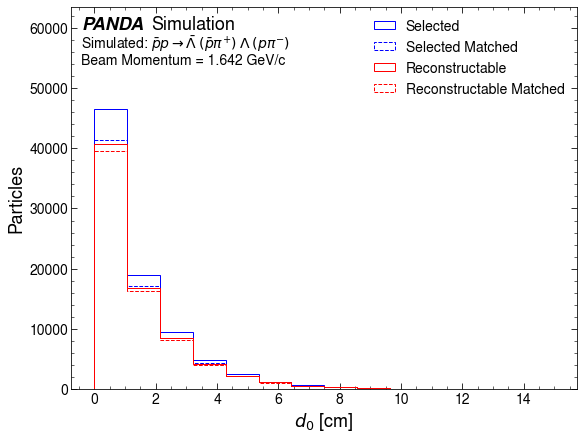

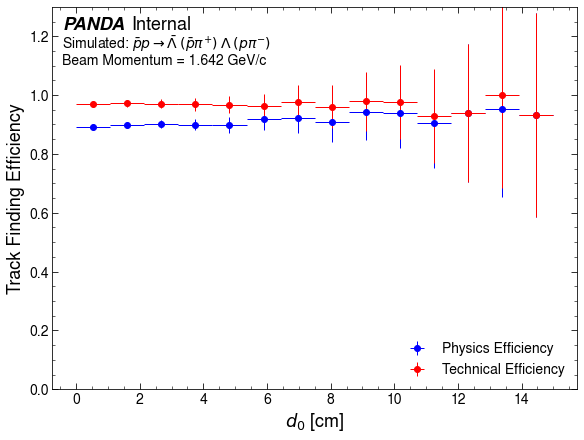

In [30]:
# vertex cuts
all_cuts = [0.0]

for cut_d0 in all_cuts:

    # select cuts
    cuts = d0 > cut_d0

    # select particles
    sel_particles = d0[cuts]  # selected (or generated)
    sel_matched_particles = d0[cuts & matched_idx]  # selected and matched
    reco_particles = d0[cuts & rectable_idx]  # selected reconstructable
    reco_matched_particles = d0[
        cuts & rectable_idx & matched_idx
    ]  # selected reconstructable and matched

    # make list of particles
    particles = [
        sel_particles,
        sel_matched_particles,
        reco_particles,
        reco_matched_particles,
    ]

    # make phi plots
    make_cmp_plot_fn(
        arrays=particles,
        configs=d0_configs,
        xlabel=r"$d_0$ [cm]",
        ymin=0.0,
        ymax=1.0,
        outname=os.path.join(outdir, f"{out_prefix}_d0_cut{cut_d0}"),
    )

    # print stats
    # print("cut_d0: {}".format(cut_d0))
    # print("efficiency (phys.): ", (sel_matched_particles.shape[0]/sel_particles.shape[0]*100))
    # print("efficiency (tech.): ", (reco_matched_particles.shape[0]/reco_particles.shape[0]*100))

___
## _Recreate the Summary from Track Evalution Script_

In [29]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.211190,2.244420,2.951081,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.991597,0.614596,-0.528416,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.374578,1.663314,1.566344,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.473503,1.421811,-0.582538,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.503124,1.358655,-0.031754,23,True,True,10


In [30]:
# Lets find Phys. and Tech. Efficicencies
sel_particles = df  # selected/generated
sel_matched_particles = df[matched_idx]  # selected and matched
reco_particles = df[rectable_idx]  # selected and reconstructable
reco_matched_particles = df[
    rectable_idx & matched_idx
]  # selected, reconstructable and matched

In [31]:
sel_particles.shape[0], sel_matched_particles.shape[0], reco_particles.shape[
    0
], reco_matched_particles.shape[0]

(85094, 76229, 75015, 72808)

- _Physics Efficiency_

In [32]:
# Physics Efficiency = (sel, matched)/sel
print(
    "efficiency (phys.): {:>3.2f}%".format(
        sel_matched_particles.shape[0] / sel_particles.shape[0] * 100
    )
)

efficiency (phys.): 89.58%


In [33]:
n_sel_particles = df.shape[0]
n_matched_sel_particles = df[df.is_matched].shape[0]
print(
    "Tracking Efficiency (Phys.): {:>3.2f}%".format(
        100 * n_matched_sel_particles / n_sel_particles
    )
)

Tracking Efficiency (Phys.): 89.58%


- _Technical Efficiency_

In [34]:
# Technical Efficiency = (sel, reconstructable, matched)/(sel, reconstructable)
print(
    "efficiency (tech.): {:>3.2f}%".format(
        reco_matched_particles.shape[0] / reco_particles.shape[0] * 100
    )
)

efficiency (tech.): 97.06%


## _Efficiency Difference Between Positive and Negative Charge_

- Lets plot difference of overall tracking efficiences for positive and negative charges.

In [35]:
# fiducial cut on charge
fiducial_pos = charge > 0
fiducial_neg = charge < 0

In [36]:
def sel_particles(var, fiducial):
    sel_particles = var[fiducial]  # selected/generated
    sel_matched_particles = var[fiducial & matched_idx]  # selected and matched
    return sel_particles, sel_matched_particles

In [37]:
def reco_particles(var, fiducial):
    reco_particles = var[fiducial & rectable_idx]  # selected and reconstructable
    reco_matched_particles = var[
        fiducial & rectable_idx & matched_idx
    ]  # selected, reconstructable and matched
    return reco_particles, reco_matched_particles

- Difference in overall efficiency

In [38]:
pt = df.pt

In [39]:
sel, sel_matched = sel_particles(pt, fiducial_pos)

sel_vals, sel_bins = np.histogram(sel, bins=pt_bins)
sel_match_vals, sel_match_bins = np.histogram(sel_matched, bins=pt_bins)

eff1, err1 = get_ratio(sel_match_vals, sel_vals)
xvals1 = (sel_bins[1:] + sel_bins[:-1]) / 2
xerrs1 = (sel_bins[1:] - sel_bins[:-1]) / 2

In [40]:
sel, sel_matched = sel_particles(pt, fiducial_neg)

sel_vals, sel_bins = np.histogram(sel, bins=pt_bins)
sel_match_vals, sel_match_bins = np.histogram(sel_matched, bins=pt_bins)

eff2, err2 = get_ratio(sel_match_vals, sel_vals)
xvals2 = (sel_bins[1:] + sel_bins[:-1]) / 2
xerrs2 = (sel_bins[1:] - sel_bins[:-1]) / 2

In [41]:
xvals = [e1 - e2 for (e1, e2) in zip(xvals1, xvals2)]
xerrs = [e1 - e2 for (e1, e2) in zip(xerrs1, xerrs2)]
eff = [e1 - e2 for (e1, e2) in zip(eff1, eff2)]
err = [math.sqrt(e1**2 + e2**2) for (e1, e2) in zip(err1, err2)]

### _Plotting Efficiency_

In [42]:
store.close()